#**<center>GPU Programmation - ENSAE</center>**

 **<center>Yannick Ly, Melchior Prugniaud</center>** 

#**GAN applying to european call option**




In this notebook we are going to implement the GAN architecture to generate prices of european call option.

## Setup

In [1]:
##############################
#  SETUP PYTHON ENVIRONMENT  #  
##############################

!pip install torch torchvision

In [1]:
!git clone https://github.com/pihk94/ProgGPU

Cloning into 'ProgGPU'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 72 (delta 40), reused 44 (delta 20), pack-reused 0
Unpacking objects: 100% (72/72), done.


## Helper functions


In [0]:
import numpy as np
import pandas as pd

def to_csv(mat, epoch):
  x = mat[1][0].cpu().detach().numpy()
  x = pd.DataFrame(x)
  x.to_csv("generation/%d.csv" % epoch)

## Architectures

In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()

        self.matrix_shape = (1, opt.matrix_height, opt.matrix_width)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(self.matrix_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        mat = self.model(z)
        mat = mat.view(mat.size(0), *self.matrix_shape)
        return mat

class Discriminator(nn.Module):
    def __init__(self, opt):
        super(Discriminator, self).__init__()

        self.matrix_shape = (1, opt.matrix_height, opt.matrix_width)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.matrix_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, mat):
        mat_flat = mat.view(mat.size(0), -1)
        validity = self.model(mat_flat)
        return validity

## GAN

In [4]:
import argparse
import os
import glob
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

##############################
#    MODEL CONFIGURATION     # 
##############################

parser = argparse.ArgumentParser()
# dataset parameters
parser.add_argument("--matrix_height", type=int, default=1024, help="size of matrix height")
parser.add_argument("--matrix_width", type=int, default=100, help="size of matrix width")
# training parameters
parser.add_argument("--cuda", type=bool, default=False, help="change to GPU mode")
parser.add_argument("--n_epochs", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=2, help="size of the batches")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# GAN parameters
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
opt = parser.parse_args("")

# GPU option
cuda = torch.cuda.is_available()
if cuda:
    print('Models moved to GPU.')
    opt.cuda = True

# Create generation directory
os.makedirs("generation", exist_ok=True)

# Configure data loader
path = glob.glob("ProgGPU/Data/data*.csv")
full_data = np.empty((len(path), 1, 32*32, 100))
for file, i in zip(path, range(len(path))):
  tmp = np.array(pd.read_csv(file).T.loc["Prix"].to_list()).reshape((1, 32*32, 100))
  full_data[i] = tmp

dataloader = DataLoader(torch.Tensor(full_data), batch_size = opt.batch_size, shuffle = True, num_workers = opt.n_cpu)

def training_loop(dataloader, opt):

  # Initialize generator and discriminator
  G = Generator(opt)
  D = Discriminator(opt)

  # Loss function
  adversarial_loss = torch.nn.BCELoss()

  # Optimizers
  optimizer_G = torch.optim.Adam(G.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
  optimizer_D = torch.optim.Adam(D.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2)) 

  # to GPU
  Tensor = torch.FloatTensor
  if opt.cuda:
      G.cuda()
      D.cuda()
      adversarial_loss.cuda()
      Tensor = torch.cuda.FloatTensor

  # Training loop
  for epoch in range(opt.n_epochs):
      for i, batch in enumerate(dataloader):

          # Adversarial ground truths
          valid = Variable(Tensor(batch.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(batch.size(0), 1).fill_(0.0), requires_grad=False)

          # Configure input
          real_prices = Variable(batch.type(Tensor))

          # -----------------
          #  Train Generator
          # -----------------

          optimizer_G.zero_grad()

          # Sample noise as generator input
          z = Variable(Tensor(np.random.normal(0, 1, (batch.shape[0], opt.latent_dim))))

          # Generate a batch of images
          gen_prices = G(z)

          # Loss measures generator's ability to fool the discriminator
          g_loss = adversarial_loss(D(gen_prices), valid)

          g_loss.backward()
          optimizer_G.step()

          # ---------------------
          #  Train Discriminator
          # ---------------------

          optimizer_D.zero_grad()

          # Measure discriminator's ability to classify real from generated samples
          real_loss = adversarial_loss(D(real_prices), valid)
          fake_loss = adversarial_loss(D(gen_prices.detach()), fake)
          d_loss = (real_loss + fake_loss) / 2

          d_loss.backward()
          optimizer_D.step()

          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
          )
      to_csv(gen_prices, epoch)

Models moved to GPU.


In [6]:
training_loop(dataloader, opt)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[Epoch 166/1000] [Batch 5/6] [D loss: 50.000450] [G loss: 7.161189]
[Epoch 167/1000] [Batch 0/6] [D loss: 50.000809] [G loss: 6.437849]
[Epoch 167/1000] [Batch 1/6] [D loss: 50.000565] [G loss: 6.822692]
[Epoch 167/1000] [Batch 2/6] [D loss: 50.000874] [G loss: 6.350849]
[Epoch 167/1000] [Batch 3/6] [D loss: 50.000374] [G loss: 7.269289]
[Epoch 167/1000] [Batch 4/6] [D loss: 50.000851] [G loss: 6.408282]
[Epoch 167/1000] [Batch 5/6] [D loss: 50.001266] [G loss: 5.984313]
[Epoch 168/1000] [Batch 0/6] [D loss: 50.000622] [G loss: 6.700805]
[Epoch 168/1000] [Batch 1/6] [D loss: 50.000648] [G loss: 6.648170]
[Epoch 168/1000] [Batch 2/6] [D loss: 50.000488] [G loss: 7.004129]
[Epoch 168/1000] [Batch 3/6] [D loss: 50.000656] [G loss: 6.648847]
[Epoch 168/1000] [Batch 4/6] [D loss: 50.000553] [G loss: 6.911251]
[Epoch 168/1000] [Batch 5/6] [D loss: 50.000675] [G loss: 6.643380]
[Epoch 169/1000] [Batch 0/6] [D loss: 

In [0]:
import matplotlib.pyplot as plt

In [28]:
np.arange(1,100,1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [0]:
df = pd.DataFrame(full_data[0][0].T)

In [21]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,...,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,2.692463,2.640530,2.644576,2.672283,2.696337,2.677102,2.632556,2.659457,2.608605,2.587596,2.604715,2.551941,2.585041,2.549384,2.576838,2.588788,2.579825,2.640815,2.594911,2.644514,2.660260,2.657772,2.697763,2.724194,2.725355,2.736617,2.732445,2.760908,2.788109,2.862994,2.884394,2.889637,2.860024,2.867917,2.842416,2.769172,2.754077,2.766304,2.835075,2.888921,...,2.846493,2.847237,2.871658,2.862174,2.879311,2.886644,2.890271,2.894901,2.918257,2.931611,2.950250,2.918939,2.938284,2.951674,2.949072,2.929988,2.895926,2.902073,2.921668,2.930842,2.929668,2.924173,2.905821,2.888474,2.889338,2.887491,2.891428,2.914599,2.892079,2.923491,2.920560,2.897326,2.910263,2.909682,2.892598,2.883956,2.888408,2.910052,2.923189,2.950711
std,0.917039,1.274000,1.519618,1.845810,2.061047,2.208986,2.361650,2.488673,2.585251,2.702665,2.885332,3.005885,3.224893,3.327342,3.404769,3.547835,3.746838,3.948556,4.018224,4.248537,4.425219,4.543176,4.675280,4.902121,5.053824,5.189923,5.234452,5.468279,5.597482,5.916274,6.133566,6.264664,6.334949,6.473165,6.598856,6.583899,6.602977,6.836205,7.024359,7.206190,...,9.349818,9.386556,9.481946,9.522793,9.605729,9.657990,9.699483,9.734515,9.783177,9.836403,9.886778,9.866967,9.932882,9.970272,10.030030,10.022815,10.025674,10.031223,10.125469,10.140461,10.179114,10.191002,10.193922,10.148548,10.148214,10.210688,10.279568,10.400609,10.390666,10.493993,10.503049,10.515439,10.562042,10.554173,10.530326,10.559536,10.568604,10.639008,10.689407,10.767114
min,0.678435,0.200511,0.067954,0.087606,0.022421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.019724,1.692804,1.503844,1.355730,1.190837,1.047666,0.951680,0.829535,0.802522,0.740987,0.607061,0.497072,0.431068,0.399783,0.345813,0.308689,0.233153,0.206864,0.184150,0.150502,0.125049,0.100345,0.104459,0.079805,0.067577,0.038140,0.039653,0.029476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

 ...]

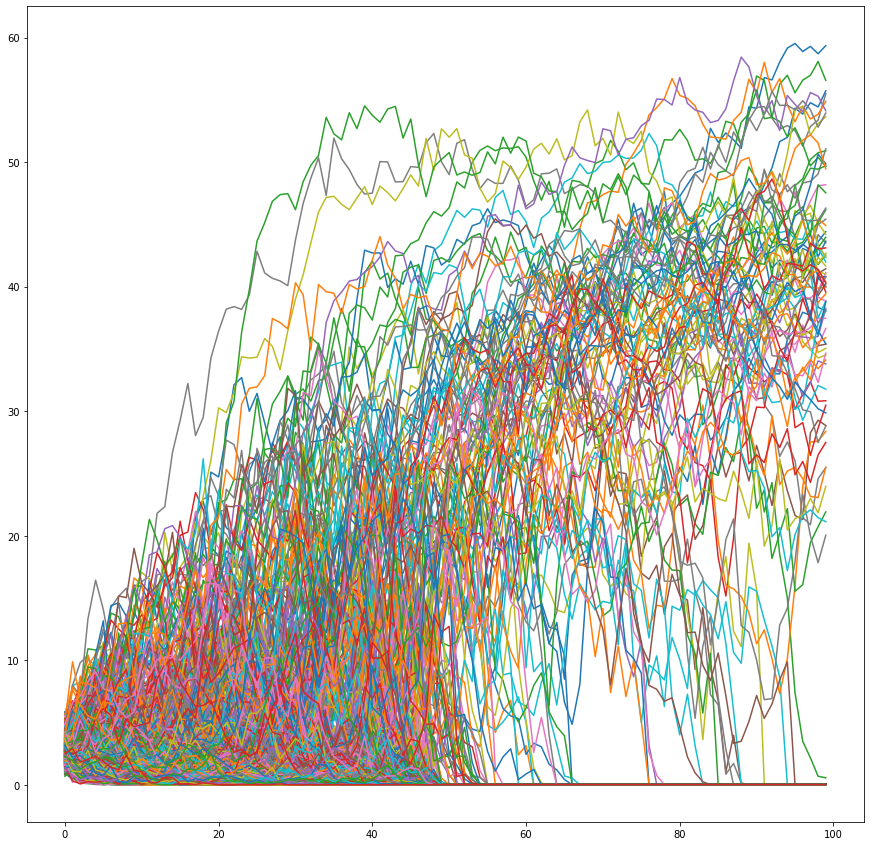

In [20]:
plt.figure(figsize=(15,15))
plt.plot(df.T)

In [34]:
full_data[0][0][0].shape

(100,)